In [ ]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 16

**Dataset Loading**

In [ ]:
path='/content/drive/MyDrive/images'
images_df=pd.read_csv('/content/images.csv')
styles_df=pd.read_csv('/content/styles.csv',on_bad_lines='skip')

In [ ]:
images_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
styles_df['filename']=styles_df['id'].astype(str) +'.jpg'

In [ ]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [ ]:

images_files=os.listdir(path)

 **Connecting colab to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
styles_df['present']=styles_df['filename'].apply(lambda x:x in images_files)

In [ ]:
styles_df=styles_df.sample(1000)# Here we are taking the 1000 images only , sample function help in selecting the number of samples

In [ ]:
styles_df=styles_df[styles_df['present']].reset_index(drop=True)


**Adjust image pixels to 224 as per vgg16 model for processing in CNN**

In [ ]:
img_size=224
datagen=ImageDataGenerator(rescale=1/255.)
generator=datagen.flow_from_dataframe(dataframe=styles_df,
                                     directory=path,
                                     target_size=(224,224),
                                     x_col='filename',
                                     class_mode=None,
                                     batch_size=32,
                                     shuffle=False,
                                     classes=None)


Found 137 validated image filenames.


In [ ]:
base_model=VGG16(include_top=False,input_shape=(img_size,img_size,3))
for layer in base_model.layers:
    layer.trainable=False


input_layer=Input(shape=(img_size,img_size,3))
x=base_model(input_layer)
output=GlobalAveragePooling2D()(x)
embedding=Model(inputs=input_layer,outputs=output)
embedding.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
X=embedding.predict(generator,verbose=1)# Verbose =1 to see the update

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 133s 17s/step


**Dimensionality Reduction using LDA**

In [ ]:
styles_df.get('column_name')
# Create a list of feature columns excluding specified ones
exclude_columns = ['id']
feature_columns = [col for col in styles_df.columns if col not in exclude_columns]

# Use the list to create X
X = styles_df[feature_columns]
print(X)
print(styles_df.columns)

    gender masterCategory subCategory   articleType baseColour  season  \
0      Men        Apparel     Topwear   Sweatshirts       Blue    Fall   
1    Women       Footwear       Shoes         Flats     Silver    Fall   
2    Women    Accessories        Bags      Handbags      Olive  Winter   
3      Men        Apparel     Topwear      Sweaters       Grey    Fall   
4    Women       Footwear       Shoes  Sports Shoes     Silver    Fall   
..     ...            ...         ...           ...        ...     ...   
132    Men        Apparel     Topwear        Shirts      Green    Fall   
133  Women    Accessories        Bags      Handbags      Black  Summer   
134  Women        Apparel     Topwear      Sweaters       Pink    Fall   
135  Women        Apparel     Topwear        Kurtas      Green    Fall   
136  Women        Apparel     Topwear       Tshirts       Pink    Fall   

       year   usage                                 productDisplayName  \
0    2011.0  Casual      United Color

5/5 ━━━━━━━━━━━━━━━━━━━━ 104s 17s/step


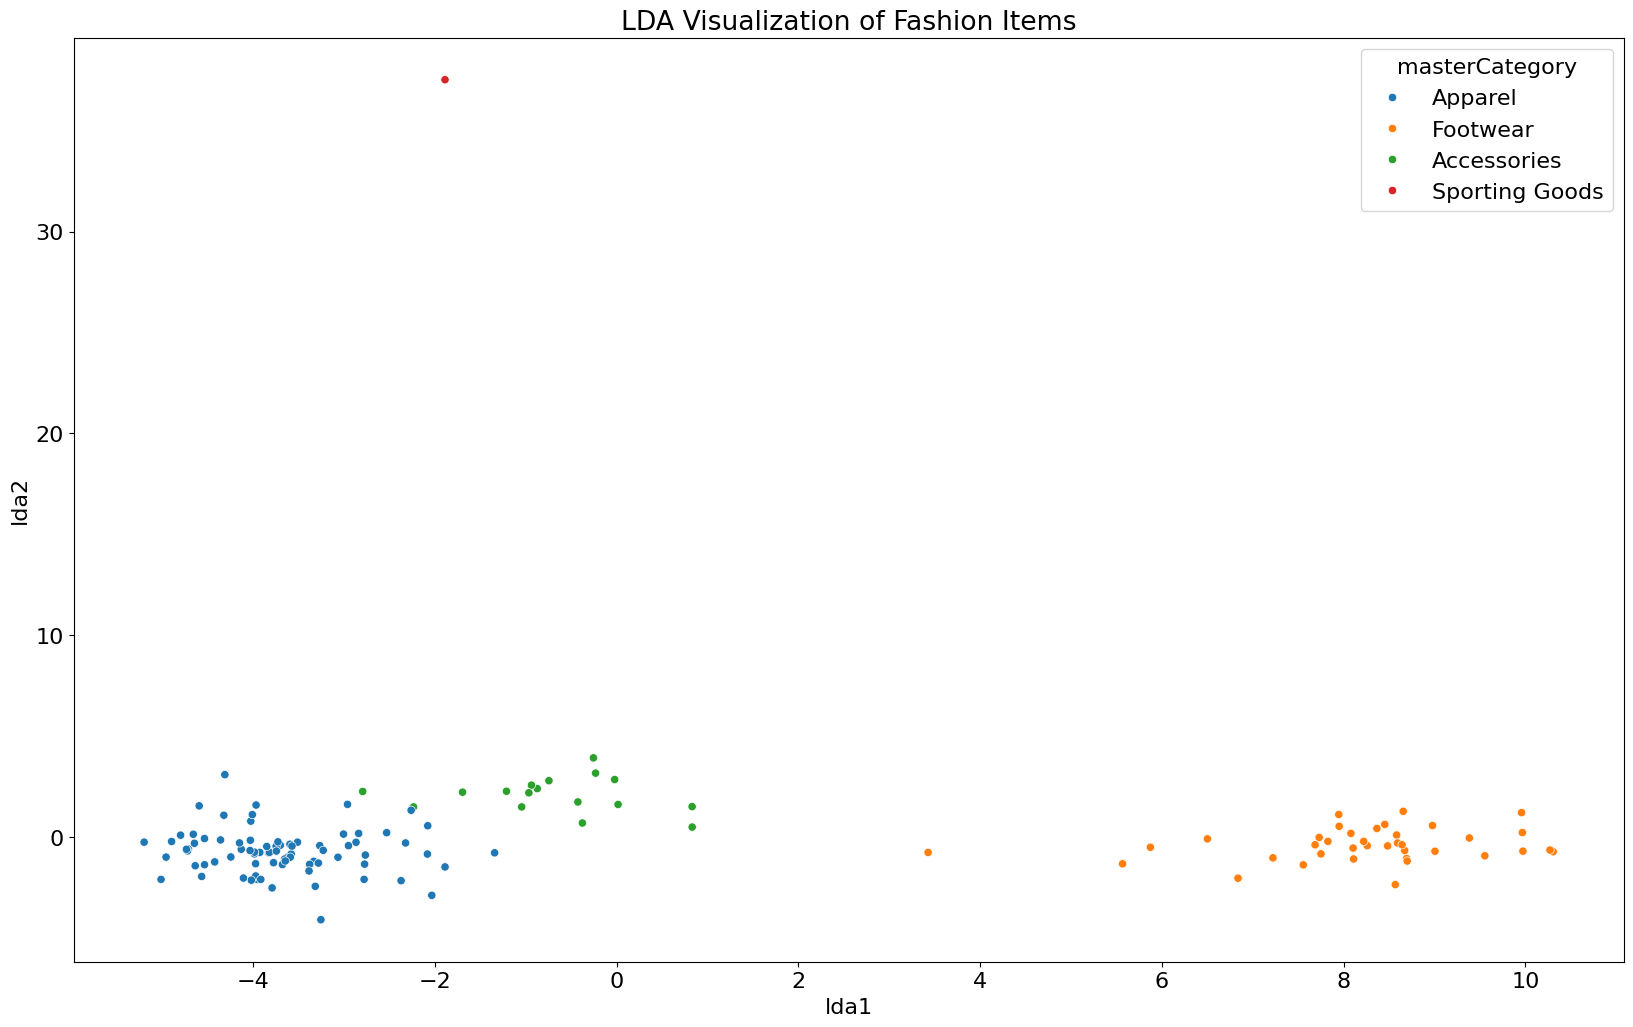

In [76]:

X = embedding.predict(generator, verbose=1)

# Prepare target variable (class labels) for LDA
y = styles_df['masterCategory'].values  # Assuming 'masterCategory' contains class labels

# Initialize and fit LDA for dimensionality reduction
lda = LDA(n_components=2)  # Set number of components to reduce to 2 dimensions
X_lda = lda.fit_transform(X, y)
styles_df[['lda1', 'lda2']] = X_lda

# Visualize the results of LDA using seaborn scatter plot
plt.figure(figsize=(20, 12))
sns.scatterplot(x='lda1', y='lda2', data=styles_df, hue='masterCategory')
plt.title('LDA Visualization of Fashion Items')
plt.show()

In [77]:
def read_img(image_path):
    image = load_img(os.path.join(path,image_path),target_size=(img_size,img_size,3))
    image = img_to_array(image)
    image = image/255.
    return image

**Implementation of KNN algorithm for Similarity Fearture finding**

In [78]:
import random
from sklearn.neighbors import KNeighborsClassifier

In [79]:
y=styles_df['id']

In [80]:

nearest_neighbors=KNeighborsClassifier(n_neighbors=7)
nearest_neighbors.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

In [81]:

styles_df=styles_df.reset_index(drop=True)

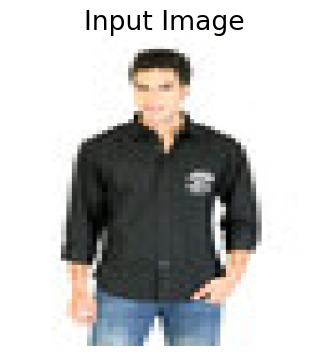

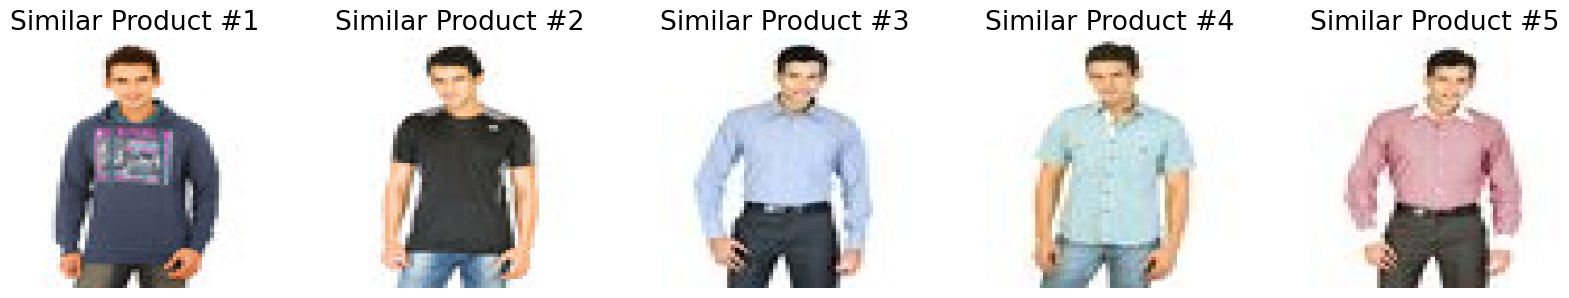

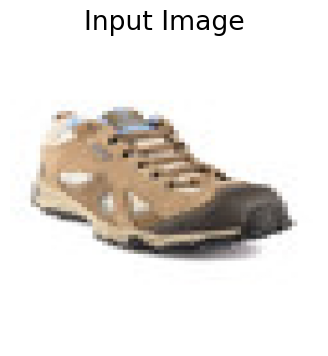

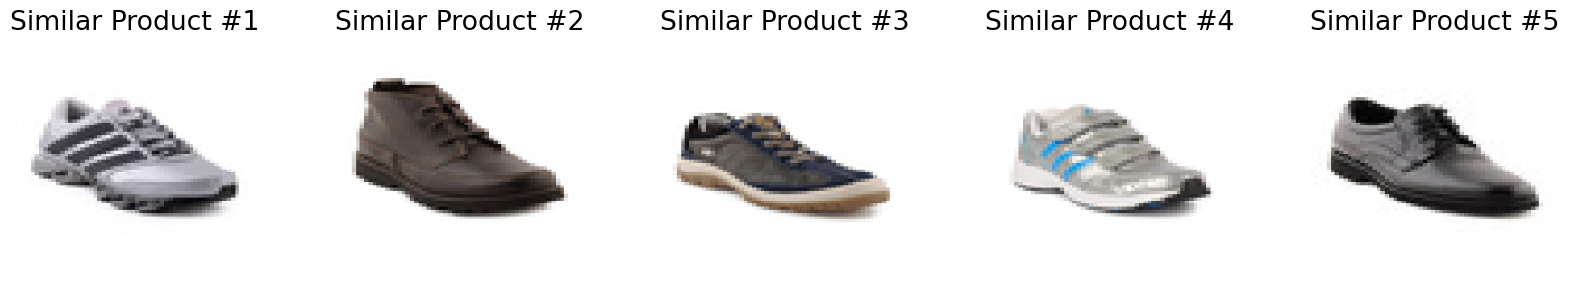

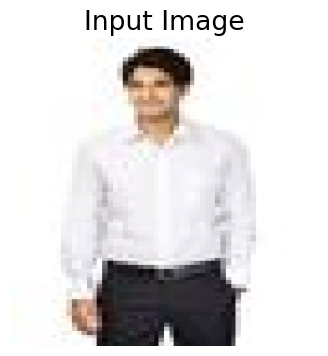

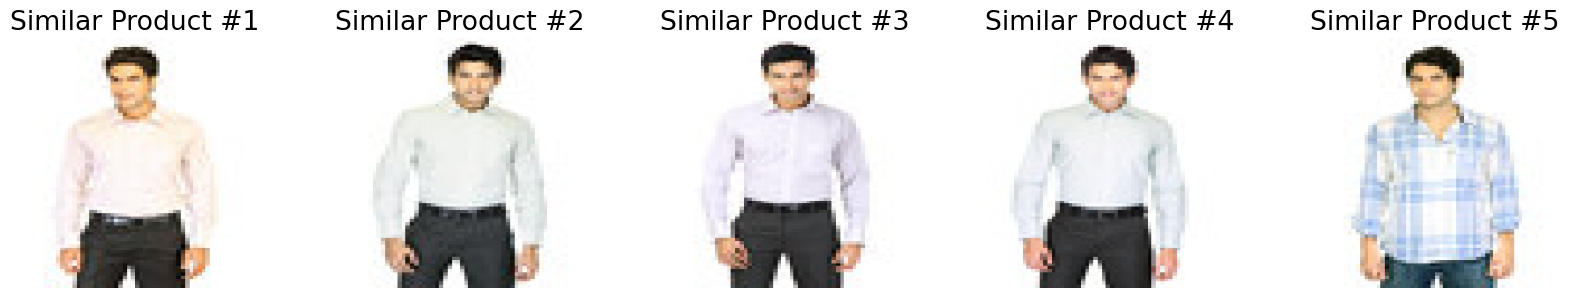

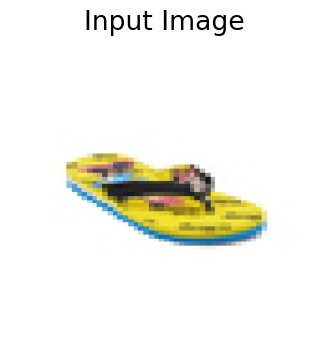

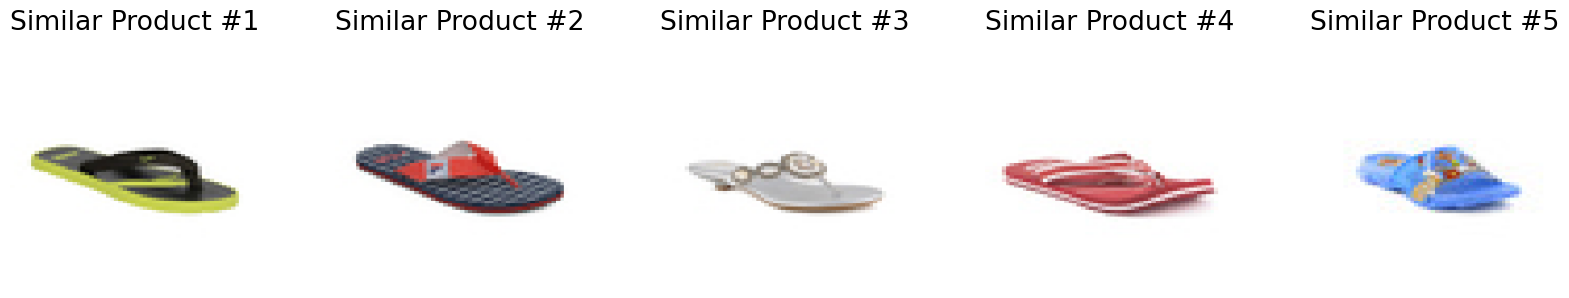

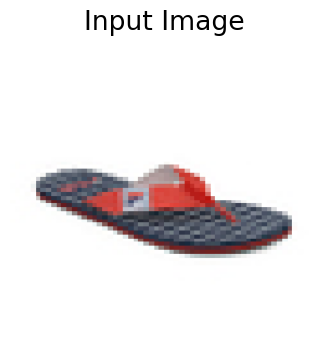

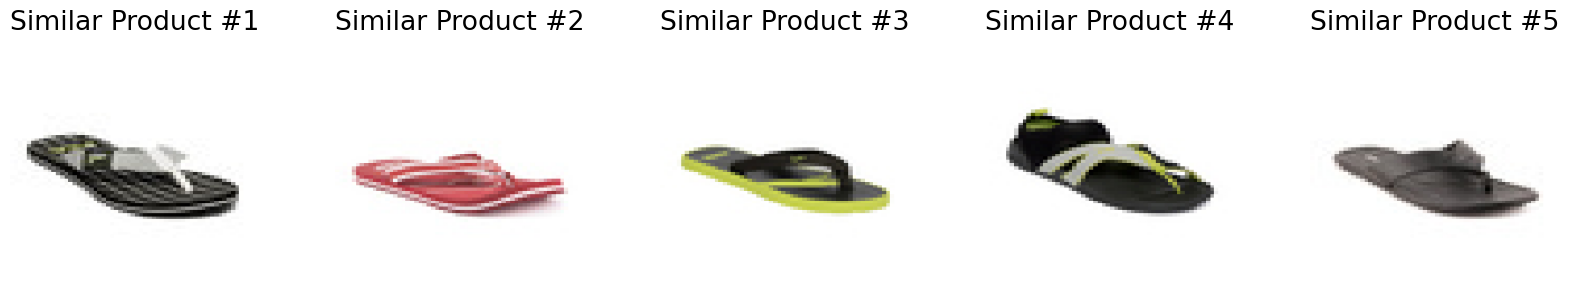

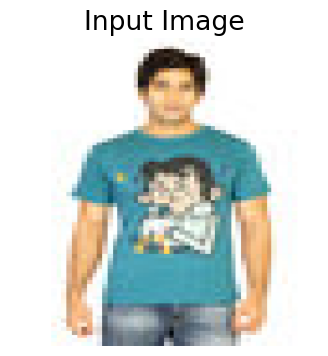

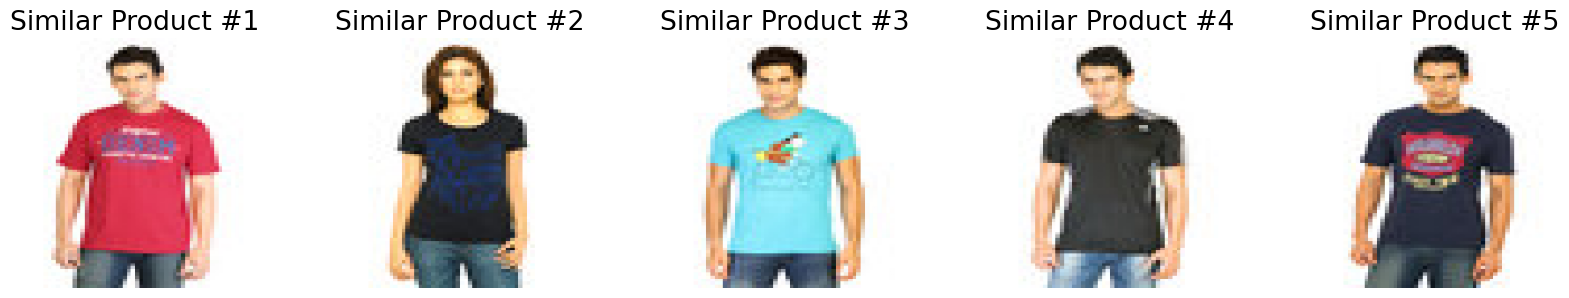

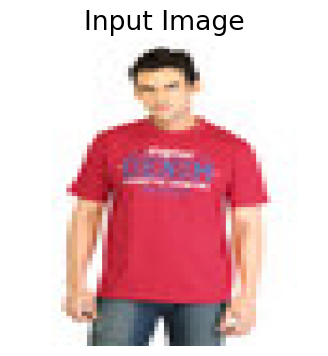

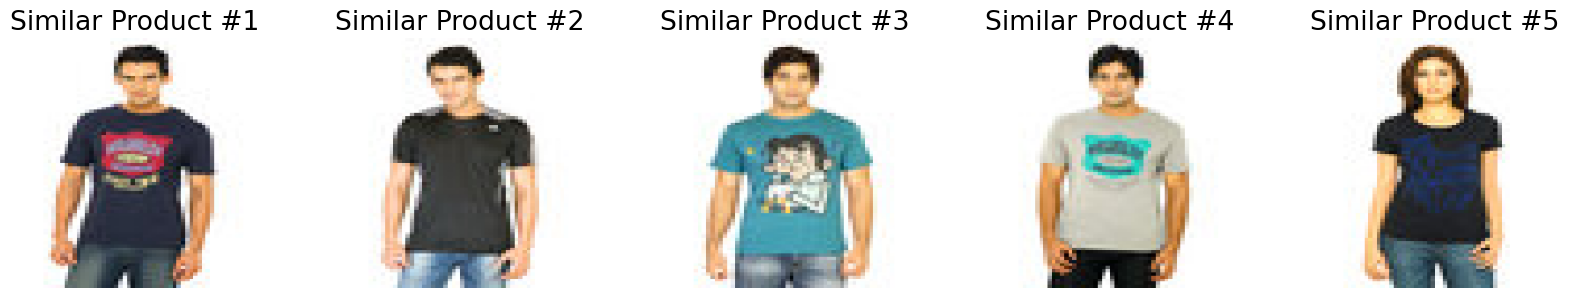

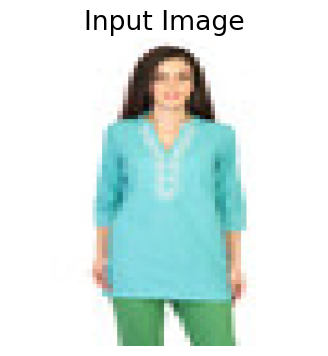

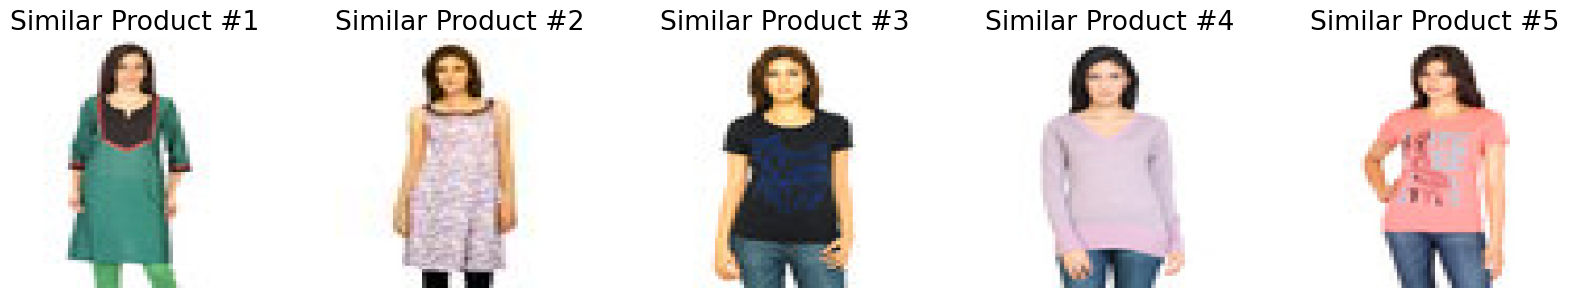

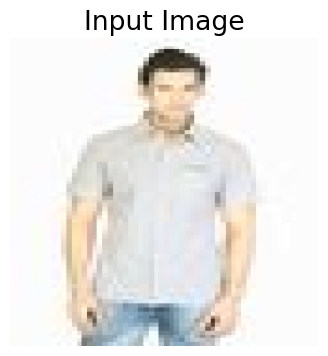

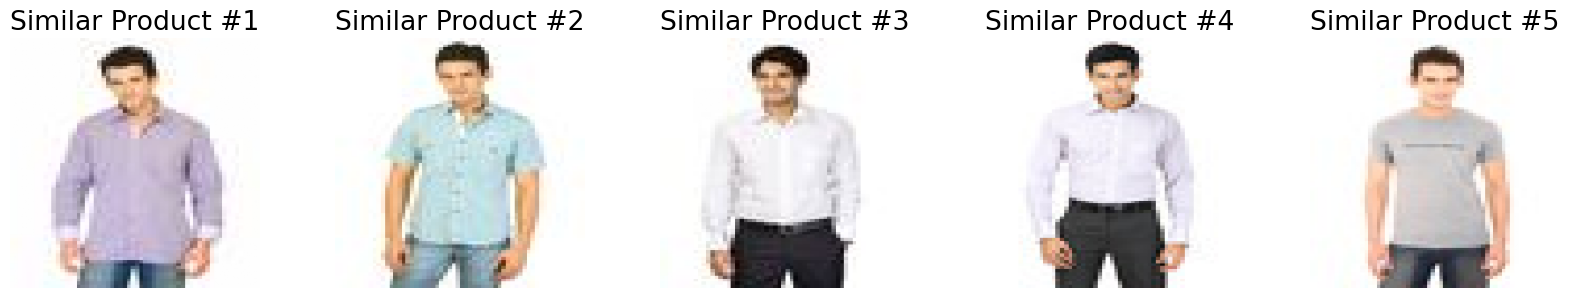

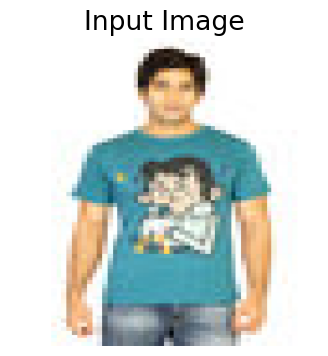

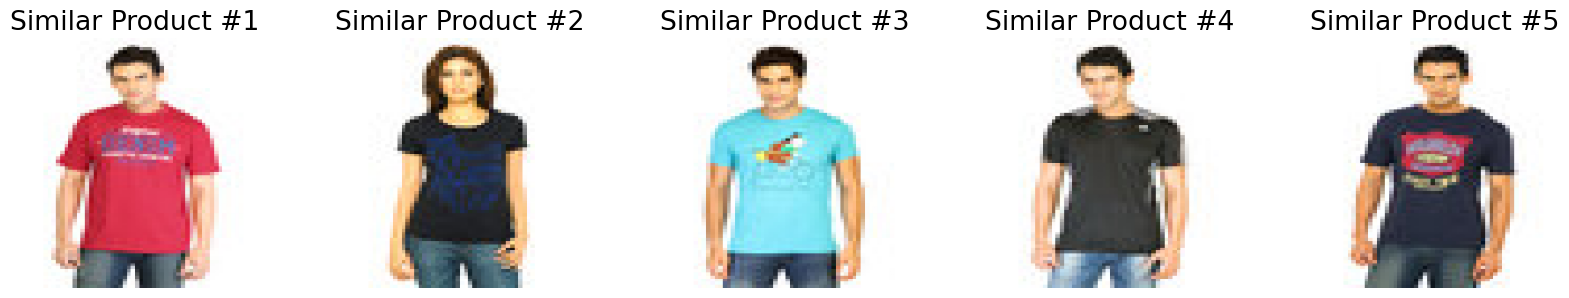

In [82]:
for _ in range(10):
    i = random.randint(0,len(styles_df))
    img1 = read_img(styles_df.loc[i,'filename'])
    dist, index = nearest_neighbors.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles_df.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')


In [83]:
import os

# Specify the directory containing your images
image_directory = '/content/drive/MyDrive/images'  # Replace with your actual image directory

# List all files in the directory
image_filenames = os.listdir(image_directory)

# Filter the list to include only image files (optional)
image_filenames = [f for f in image_filenames if f.endswith(('.jpg', '.jpeg', '.png'))]

# Now you can use these filenames in your code
for filename in image_filenames:
    image_path = os.path.join(image_directory, filename)  # Construct the full path
    print(image_path)  # Print the full path or use it in your processing

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/images/16488.jpg
/content/drive/MyDrive/images/16455.jpg
/content/drive/MyDrive/images/16476.jpg
/content/drive/MyDrive/images/16501.jpg
/content/drive/MyDrive/images/16498.jpg
/content/drive/MyDrive/images/1647.jpg
/content/drive/MyDrive/images/16471.jpg
/content/drive/MyDrive/images/16495.jpg
/content/drive/MyDrive/images/16468.jpg
/content/drive/MyDrive/images/16505.jpg
/content/drive/MyDrive/images/16567.jpg
/content/drive/MyDrive/images/16536.jpg
/content/drive/MyDrive/images/16557.jpg
/content/drive/MyDrive/images/16529.jpg
/content/drive/MyDrive/images/1651.jpg
/content/drive/MyDrive/images/16548.jpg
/content/drive/MyDrive/images/16544.jpg
/content/drive/MyDrive/images/16518.jpg
/content/drive/MyDrive/images/16533.jpg
/content/drive/MyDrive/images/16543.jpg
/content/drive/MyDrive/images/1654.jpg
/content/drive/MyDrive/images/16547.jpg
/content/drive/MyDrive/images/16555.jpg
/content/drive/MyDrive/images/16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')